### Accessing google drive

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hasanmoni","key":"5a2a53290ee4866258b0dfd1198cabb0"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


### Loading necessary library

In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import model_selection
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import random
import re

import nltk
nltk.download('stopwords')

import optuna 
from functools import partial
from skopt import space


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading dataset

In [9]:
# Loading dataset
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')

#####################################################################
# Feature Engineering
######################################################################

In [10]:
# Checking null data
print(data.isnull().sum())


id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [11]:

#total number and percent of null value 
print('null value number = {} and percent = {} '.format((data['title'].isnull().sum()),   (data['title'].isnull().sum() *100)/len(data['title'])))
print('null value number = {} and percent = {} '.format((data['author'].isnull().sum()),   (data['author'].isnull().sum() *100)/len(data['title'])))
print('null value number = {} and percent = {} '.format((data['text'].isnull().sum()),   (data['text'].isnull().sum() *100)/len(data['title'])))


null value number = 558 and percent = 2.6826923076923075 
null value number = 1957 and percent = 9.408653846153847 
null value number = 39 and percent = 0.1875 


In [12]:
#dropping null value
data.dropna(axis=0, inplace=True)
print('Shape after dropping null value :', data.shape)

Shape after dropping null value : (18285, 5)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



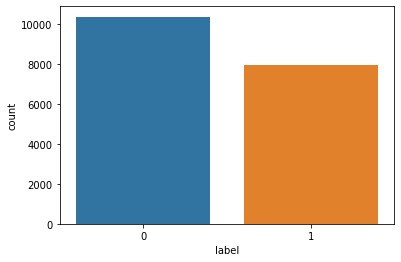

In [13]:
#checking balanced or imbalanced data
sns.countplot(data['label'])

In [14]:
#index resetting
data = data.reset_index()
data.drop(['index','id'], axis=1, inplace=True)
data.columns.rename={'level_0':'id'}
print(data.head())

                                               title  ... label
0  House Dem Aide: We Didn’t Even See Comey’s Let...  ...     1
1  FLYNN: Hillary Clinton, Big Woman on Campus - ...  ...     0
2                  Why the Truth Might Get You Fired  ...     1
3  15 Civilians Killed In Single US Airstrike Hav...  ...     1
4  Iranian woman jailed for fictional unpublished...  ...     1

[5 rows x 4 columns]


In [15]:
#printing a text
print(data['text'][0])

House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) 
With apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. 
As we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emails 

In [16]:
#printing a text
print(data['text'][0])

House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) 
With apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. 
As we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emails 

###############################################################################
# Text cleaning
###############################################################################

In [17]:
ps = PorterStemmer()

corpus = []

for row in range(0,len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data['text'][row])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [18]:
#printing a paragraph
print(corpus[2])

truth might get fire octob tension intellig analyst polit policymak alway honest assess desir result latter often overwhelm former iraq war write lawrenc davidson lawrenc davidson might wonder foreign polici maker repeatedli make bad choic insight might drawn follow analysi action play unit state lesson probabl univers back earli spring georg w bush initi invas iraq one key public reason claim countri dictat saddam hussein verg develop nuclear weapon hide weapon mass destruct real reason went beyond charg includ long rang plan regim chang middl east presid georg w bush vice presid dick cheney receiv oval offic brief cia director georg tenet also present chief staff andi card right white hous photo purpos concentr belief iraq becom hostil nuclear power presid bush close associ accept scenario readili short answer bush want inde need believ rational invad iraq first tri connect saddam hussein attack u though never gave stratagem lack evid made difficult ralli american peopl alreadi fixat

##############################################################################
# Encoding
##############################################################################

In [19]:
#Bag of Words using TfidfVectorizer()
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X = tfidf.fit_transform(corpus).toarray()
print('Shape of X is :',X.shape)

Shape of X is : (18285, 5000)


In [20]:
#printing some feature names
print(tfidf.get_feature_names()[:10])

['aaron', 'abandon', 'abc', 'abe', 'abedin', 'abil', 'abl', 'abort', 'abroad', 'absenc']


In [21]:
#printing parameter
print(tfidf.get_params())

{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': 5000, 'min_df': 1, 'ngram_range': (1, 3), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': None, 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}


In [22]:
#label data
y = data['label']
print('Length of y :',len(y))

Length of y : 18285


##########################################################################
# Dividing dataset
##########################################################################

In [23]:
#dividing dataset for train and test
Xtrain,xtest,Ytrain,ytest = train_test_split(X,y, test_size=.2, random_state=0)
print('Shape of Xtrain :',Xtrain.shape)
print('Shape of xtest :',xtest.shape)
print('Shap of Ytrain :',Ytrain.shape)
print('Shape of ytest :',ytest.shape)

Shape of Xtrain : (14628, 5000)
Shape of xtest : (3657, 5000)
Shap of Ytrain : (14628,)
Shape of ytest : (3657,)


In [24]:
#printing some BOW words data
df = pd.DataFrame(Xtrain, columns=tfidf.get_feature_names())
df.head()

,aaron,abandon,abc,abe,abedin,abil,abl,abort,abroad,absenc,absolut,absorb,absurd,abu,abus,academ,academi,acceler,accept,access,access pipelin,accid,accommod,accompani,accomplish,accord,accord report,account,accumul,accur,accus,achiev,acid,acknowledg,acquir,acr,across,across countri,act,action,...,written,wrong,wrongdo,wrote,wrote twitter,www,xi,yahoo,yard,ye,yeah,year,year ago,year later,year mr,year old,year said,year sinc,yell,yellow,yemen,yesterday,yet,yet anoth,yiannopoulo,yield,york,york citi,york time,yorker,young,young peopl,younger,youth,youtub,zero,zika,zionist,zone,zu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068937,0.0,0.119721,0.0,0.0,0.0,0.076599,0.0,0.0,0.0,0.0,0.0,0.175088,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.016152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011834,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.156408,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.028654,0.0,0.0,0.0,0.0,0.017074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04646,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074315,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037168,0.0,0.025591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022699,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0



##########################################################################
# Hyperparameter tuning using optuna
##########################################################################

In [34]:
def optimize(trial, x, y):
    C = trial.suggest_uniform('C', .001, 1)
    average = trial.suggest_categorical('average', [True, False])
    early_stopping = trial.suggest_categorical('early_stopping', [True, False])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    max_iter = trial.suggest_int('max_iter', 100, 1500)
    tol = trial.suggest_uniform('tol', 0.001, .08)
    validation_fraction = trial.suggest_uniform('validation_fraction', 0.1, 0.9)
    n_iter_no_change = trial.suggest_int('n_iter_no_change=5', 1, 9)
    shuffle = trial.suggest_categorical('shuffle', [True, False])
    verbose = trial.suggest_int('verbose', 0, 3)
    n_jobs = trial.suggest_int('n_jobs', 0, 5)
    random_state = trial.suggest_int('random_state', 0, 5)




    #criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    #n_estimators = trial.suggest_int("n_estimators", 100, 1500)
    #max_depth = trial.suggest_int("max_depth", 3, 15)
    #max_features = trial.suggest_uniform("max_features", 0.01, 1.0)





    
    model = PassiveAggressiveClassifier(
        C = C,
        average = average,
        early_stopping = early_stopping,
        fit_intercept = fit_intercept,
        max_iter = max_iter,
        tol = tol,
        validation_fraction = validation_fraction,
        n_iter_no_change = n_iter_no_change,
        shuffle = shuffle,
        verbose = verbose,
        n_jobs = n_jobs,
        random_state = random_state,
        )

    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []
    for idx in kf.split(X=x, y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        
        xtest = x[test_idx]
        ytest = y[test_idx]
        
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        fold_acc = metrics.accuracy_score(ytest, preds)
        accuracies.append(fold_acc)
        
    return -1.0 * np.mean(accuracies)   # printing accuracy in negative


In [35]:
optimization_function = partial(optimize, x=X, y=y)  

In [36]:
study = optuna.create_study(direction='minimize')
study.optimize(optimization_function, n_trials=15)

[I 2020-10-01 17:37:37,898] A new study created in memory with name: no-name-aa68cf24-a36e-47fc-9ff6-e2c7558a4c66


-- Epoch 1
Norm: 22.64, NNZs: 4987, Bias: 0.000000, T: 2900, Avg. loss: 0.073941
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 28.07, NNZs: 4987, Bias: 0.000000, T: 5800, Avg. loss: 0.030430
Total training time: 0.26 seconds.
-- Epoch 3
Norm: 31.63, NNZs: 4987, Bias: 0.000000, T: 8700, Avg. loss: 0.018898
Total training time: 0.44 seconds.
-- Epoch 4
Norm: 34.24, NNZs: 4987, Bias: 0.000000, T: 11600, Avg. loss: 0.012703
Total training time: 0.62 seconds.
-- Epoch 5
Norm: 36.15, NNZs: 4987, Bias: 0.000000, T: 14500, Avg. loss: 0.008799
Total training time: 0.81 seconds.
-- Epoch 6
Norm: 37.48, NNZs: 4987, Bias: 0.000000, T: 17400, Avg. loss: 0.006181
Total training time: 0.99 seconds.
-- Epoch 7
Norm: 38.39, NNZs: 4987, Bias: 0.000000, T: 20300, Avg. loss: 0.004516
Total training time: 1.18 seconds.
-- Epoch 8
Norm: 39.04, NNZs: 4987, Bias: 0.000000, T: 23200, Avg. loss: 0.003491
Total training time: 1.36 seconds.
Convergence after 8 epochs took 1.46 seconds
-- Epoch 1
Norm: 22.72

[I 2020-10-01 17:37:47,342] Trial 0 finished with value: -0.9283565764287669 and parameters: {'C': 0.40394532236339953, 'average': True, 'early_stopping': True, 'fit_intercept': False, 'max_iter': 118, 'tol': 0.035707075930749364, 'validation_fraction': 0.8006718555316609, 'n_iter_no_change=5': 7, 'shuffle': False, 'verbose': 1, 'n_jobs': 0, 'random_state': 5}. Best is trial 0 with value: -0.9283565764287669.


-- Epoch 1
Norm: 33.42, NNZs: 4996, Bias: 1.014831, T: 14557, Avg. loss: 0.258370
Total training time: 0.25 seconds.
-- Epoch 2
Norm: 41.86, NNZs: 4996, Bias: 1.093092, T: 29114, Avg. loss: 0.129136
Total training time: 0.48 seconds.
-- Epoch 3
Norm: 47.88, NNZs: 4996, Bias: 0.917228, T: 43671, Avg. loss: 0.098097
Total training time: 0.71 seconds.
-- Epoch 4
Norm: 52.63, NNZs: 4996, Bias: 0.993149, T: 58228, Avg. loss: 0.080295
Total training time: 0.94 seconds.
-- Epoch 5
Norm: 56.73, NNZs: 4996, Bias: 0.952404, T: 72785, Avg. loss: 0.068692
Total training time: 1.16 seconds.
-- Epoch 6
Norm: 60.28, NNZs: 4996, Bias: 1.134905, T: 87342, Avg. loss: 0.059031
Total training time: 1.38 seconds.
-- Epoch 7
Norm: 63.47, NNZs: 4996, Bias: 1.313868, T: 101899, Avg. loss: 0.051628
Total training time: 1.61 seconds.
-- Epoch 8
Norm: 66.36, NNZs: 4996, Bias: 1.316440, T: 116456, Avg. loss: 0.045651
Total training time: 1.83 seconds.
-- Epoch 9
Norm: 68.96, NNZs: 4996, Bias: 1.373277, T: 131013,

[I 2020-10-01 17:38:01,350] Trial 1 finished with value: -0.9468963631391851 and parameters: {'C': 0.24464824862337942, 'average': False, 'early_stopping': False, 'fit_intercept': True, 'max_iter': 1190, 'tol': 0.02811335843988968, 'validation_fraction': 0.8565651203585133, 'n_iter_no_change=5': 8, 'shuffle': False, 'verbose': 3, 'n_jobs': 3, 'random_state': 0}. Best is trial 1 with value: -0.9468963631391851.


-- Epoch 1
Norm: 34.18, NNZs: 4996, Bias: 0.000000, T: 9927, Avg. loss: 0.172177
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 42.68, NNZs: 4996, Bias: 0.000000, T: 19854, Avg. loss: 0.081736
Total training time: 0.45 seconds.
-- Epoch 3
Norm: 48.60, NNZs: 4996, Bias: 0.000000, T: 29781, Avg. loss: 0.058447
Total training time: 0.74 seconds.
-- Epoch 4
Norm: 53.20, NNZs: 4996, Bias: 0.000000, T: 39708, Avg. loss: 0.045372
Total training time: 1.01 seconds.
-- Epoch 5
Norm: 57.01, NNZs: 4996, Bias: 0.000000, T: 49635, Avg. loss: 0.036752
Total training time: 1.28 seconds.
-- Epoch 6
Norm: 60.20, NNZs: 4996, Bias: 0.000000, T: 59562, Avg. loss: 0.030306
Total training time: 1.55 seconds.
Convergence after 6 epochs took 1.66 seconds
-- Epoch 1
Norm: 33.92, NNZs: 4993, Bias: 0.000000, T: 9926, Avg. loss: 0.167958
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 42.46, NNZs: 4994, Bias: 0.000000, T: 19852, Avg. loss: 0.079935
Total training time: 0.44 seconds.
-- Epoch 3
Norm: 48.3

[I 2020-10-01 17:38:11,386] Trial 2 finished with value: -0.9412633305988516 and parameters: {'C': 0.42403862120504776, 'average': False, 'early_stopping': True, 'fit_intercept': False, 'max_iter': 1130, 'tol': 0.03500852039842981, 'validation_fraction': 0.3182033873288497, 'n_iter_no_change=5': 5, 'shuffle': False, 'verbose': 3, 'n_jobs': 2, 'random_state': 5}. Best is trial 1 with value: -0.9468963631391851.


-- Epoch 1
Norm: 44.20, NNZs: 4998, Bias: 1.108147, T: 14557, Avg. loss: 0.235152
Total training time: 0.25 seconds.
-- Epoch 2
Norm: 55.71, NNZs: 4998, Bias: 0.853782, T: 29114, Avg. loss: 0.112672
Total training time: 0.48 seconds.
-- Epoch 3
Norm: 63.44, NNZs: 4998, Bias: 1.084343, T: 43671, Avg. loss: 0.082688
Total training time: 0.71 seconds.
Convergence after 3 epochs took 0.71 seconds
-- Epoch 1
Norm: 44.30, NNZs: 4996, Bias: 1.072340, T: 14556, Avg. loss: 0.233612
Total training time: 0.24 seconds.
-- Epoch 2
Norm: 55.53, NNZs: 4997, Bias: 0.023222, T: 29112, Avg. loss: 0.110263
Total training time: 0.47 seconds.
-- Epoch 3
Norm: 63.14, NNZs: 4997, Bias: 1.072429, T: 43668, Avg. loss: 0.080347
Total training time: 0.70 seconds.
Convergence after 3 epochs took 0.70 seconds
-- Epoch 1
Norm: 44.66, NNZs: 5000, Bias: 1.039417, T: 14555, Avg. loss: 0.238465
Total training time: 0.24 seconds.
-- Epoch 2
Norm: 55.99, NNZs: 5000, Bias: 0.280647, T: 29110, Avg. loss: 0.116071
Total tra

[I 2020-10-01 17:38:16,340] Trial 3 finished with value: -0.9561936013125513 and parameters: {'C': 0.5228491974484089, 'average': False, 'early_stopping': False, 'fit_intercept': True, 'max_iter': 1245, 'tol': 0.0684483076130318, 'validation_fraction': 0.2170058500075257, 'n_iter_no_change=5': 1, 'shuffle': True, 'verbose': 2, 'n_jobs': 0, 'random_state': 5}. Best is trial 3 with value: -0.9561936013125513.


-- Epoch 1
Norm: 38.21, NNZs: 4997, Bias: 0.000000, T: 12439, Avg. loss: 0.196604
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 47.53, NNZs: 4997, Bias: 0.000000, T: 24878, Avg. loss: 0.094736
Total training time: 0.52 seconds.
-- Epoch 3
Norm: 54.18, NNZs: 4997, Bias: 0.000000, T: 37317, Avg. loss: 0.069693
Total training time: 0.83 seconds.
-- Epoch 4
Norm: 59.36, NNZs: 4997, Bias: 0.000000, T: 49756, Avg. loss: 0.054750
Total training time: 1.14 seconds.
-- Epoch 5
Norm: 63.61, NNZs: 4997, Bias: 0.000000, T: 62195, Avg. loss: 0.044730
Total training time: 1.45 seconds.
-- Epoch 6
Norm: 67.21, NNZs: 4997, Bias: 0.000000, T: 74634, Avg. loss: 0.037330
Total training time: 1.76 seconds.
Convergence after 6 epochs took 1.86 seconds
-- Epoch 1
Norm: 37.96, NNZs: 4995, Bias: 0.000000, T: 12440, Avg. loss: 0.193153
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 47.28, NNZs: 4995, Bias: 0.000000, T: 24880, Avg. loss: 0.092915
Total training time: 0.53 seconds.
-- Epoch 3
Norm: 53

[I 2020-10-01 17:38:27,495] Trial 4 finished with value: -0.944380639868745 and parameters: {'C': 0.4729781587434572, 'average': False, 'early_stopping': True, 'fit_intercept': False, 'max_iter': 298, 'tol': 0.05572514974917908, 'validation_fraction': 0.1456285383185577, 'n_iter_no_change=5': 5, 'shuffle': False, 'verbose': 1, 'n_jobs': 0, 'random_state': 5}. Best is trial 3 with value: -0.9561936013125513.


-- Epoch 1
Norm: 21.98, NNZs: 4997, Bias: 0.000000, T: 7534, Avg. loss: 0.178440
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 28.14, NNZs: 4997, Bias: 0.000000, T: 15068, Avg. loss: 0.091582
Total training time: 0.46 seconds.
-- Epoch 3
Norm: 32.42, NNZs: 4997, Bias: 0.000000, T: 22602, Avg. loss: 0.069440
Total training time: 0.75 seconds.
Convergence after 3 epochs took 0.85 seconds
-- Epoch 1
Norm: 21.93, NNZs: 4999, Bias: 0.000000, T: 7536, Avg. loss: 0.179548
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 28.22, NNZs: 4999, Bias: 0.000000, T: 15072, Avg. loss: 0.092334
Total training time: 0.48 seconds.
-- Epoch 3
Norm: 32.42, NNZs: 4999, Bias: 0.000000, T: 22608, Avg. loss: 0.070143
Total training time: 0.76 seconds.
Convergence after 3 epochs took 0.87 seconds
-- Epoch 1
Norm: 21.95, NNZs: 4997, Bias: 0.000000, T: 7538, Avg. loss: 0.183230
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 28.21, NNZs: 4997, Bias: 0.000000, T: 15076, Avg. loss: 0.094954
Total traini

[I 2020-10-01 17:38:33,673] Trial 5 finished with value: -0.9307629204265793 and parameters: {'C': 0.16238623902036767, 'average': True, 'early_stopping': True, 'fit_intercept': False, 'max_iter': 965, 'tol': 0.03156467452077985, 'validation_fraction': 0.4819859388112281, 'n_iter_no_change=5': 2, 'shuffle': True, 'verbose': 1, 'n_jobs': 5, 'random_state': 0}. Best is trial 3 with value: -0.9561936013125513.


-- Epoch 1
Norm: 43.06, NNZs: 4997, Bias: 0.000000, T: 9850, Avg. loss: 0.159366
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 52.61, NNZs: 4999, Bias: 0.000000, T: 19700, Avg. loss: 0.067407
Total training time: 0.45 seconds.
Convergence after 2 epochs took 0.55 seconds
-- Epoch 1
Norm: 42.61, NNZs: 4996, Bias: 0.000000, T: 9845, Avg. loss: 0.155253
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 51.81, NNZs: 4996, Bias: 0.000000, T: 19690, Avg. loss: 0.064891
Total training time: 0.45 seconds.
Convergence after 2 epochs took 0.56 seconds
-- Epoch 1
Norm: 42.93, NNZs: 4994, Bias: 0.000000, T: 9844, Avg. loss: 0.158411
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 52.46, NNZs: 4994, Bias: 0.000000, T: 19688, Avg. loss: 0.069003
Total training time: 0.45 seconds.
Convergence after 2 epochs took 0.55 seconds
-- Epoch 1
Norm: 42.55, NNZs: 4995, Bias: 0.000000, T: 9845, Avg. loss: 0.155399
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 51.96, NNZs: 4995, Bias: 0.000000

[I 2020-10-01 17:38:38,306] Trial 6 finished with value: -0.9407711238720262 and parameters: {'C': 0.8936363643864574, 'average': False, 'early_stopping': True, 'fit_intercept': False, 'max_iter': 564, 'tol': 0.03665027817961133, 'validation_fraction': 0.32358485737839593, 'n_iter_no_change=5': 1, 'shuffle': False, 'verbose': 1, 'n_jobs': 5, 'random_state': 4}. Best is trial 3 with value: -0.9561936013125513.


-- Epoch 1
Norm: 33.92, NNZs: 4994, Bias: 0.000000, T: 9975, Avg. loss: 0.172248
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 42.29, NNZs: 4995, Bias: 0.000000, T: 19950, Avg. loss: 0.083090
Total training time: 0.55 seconds.
-- Epoch 3
Norm: 48.26, NNZs: 4995, Bias: 0.000000, T: 29925, Avg. loss: 0.060376
Total training time: 0.88 seconds.
-- Epoch 4
Norm: 52.98, NNZs: 4995, Bias: 0.000000, T: 39900, Avg. loss: 0.046395
Total training time: 1.20 seconds.
-- Epoch 5
Norm: 56.95, NNZs: 4995, Bias: 0.000000, T: 49875, Avg. loss: 0.037889
Total training time: 1.52 seconds.
-- Epoch 6
Norm: 60.23, NNZs: 4995, Bias: 0.000000, T: 59850, Avg. loss: 0.030874
Total training time: 1.85 seconds.
-- Epoch 7
Norm: 62.88, NNZs: 4995, Bias: 0.000000, T: 69825, Avg. loss: 0.025078
Total training time: 2.17 seconds.
-- Epoch 8
Norm: 65.23, NNZs: 4995, Bias: 0.000000, T: 79800, Avg. loss: 0.021576
Total training time: 2.50 seconds.
-- Epoch 9
Norm: 67.16, NNZs: 4995, Bias: 0.000000, T: 89775, Avg

[I 2020-10-01 17:38:56,634] Trial 7 finished with value: -0.9420289855072463 and parameters: {'C': 0.40993845739947327, 'average': True, 'early_stopping': True, 'fit_intercept': False, 'max_iter': 1343, 'tol': 0.05308608750414457, 'validation_fraction': 0.31507143225121387, 'n_iter_no_change=5': 9, 'shuffle': True, 'verbose': 1, 'n_jobs': 0, 'random_state': 2}. Best is trial 3 with value: -0.9561936013125513.


-- Epoch 1
Norm: 40.53, NNZs: 4994, Bias: 0.199304, T: 8087, Avg. loss: 0.150328
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 50.36, NNZs: 4994, Bias: 0.780306, T: 16174, Avg. loss: 0.067703
Total training time: 0.47 seconds.
-- Epoch 3
Norm: 56.84, NNZs: 4994, Bias: 1.524827, T: 24261, Avg. loss: 0.044366
Total training time: 0.76 seconds.
Convergence after 3 epochs took 0.86 seconds
-- Epoch 1
Norm: 40.88, NNZs: 4993, Bias: -0.451517, T: 8084, Avg. loss: 0.149591
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 50.46, NNZs: 4995, Bias: 1.221945, T: 16168, Avg. loss: 0.065095
Total training time: 0.47 seconds.
Convergence after 2 epochs took 0.57 seconds
-- Epoch 1
Norm: 40.94, NNZs: 4995, Bias: -0.072782, T: 8084, Avg. loss: 0.153450
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 50.49, NNZs: 4997, Bias: 1.243139, T: 16168, Avg. loss: 0.068701
Total training time: 0.47 seconds.
Convergence after 2 epochs took 0.57 seconds
-- Epoch 1
Norm: 41.19, NNZs: 4994, Bias: 1.007

[I 2020-10-01 17:39:01,652] Trial 8 finished with value: -0.9440525020508612 and parameters: {'C': 0.6889174019050099, 'average': True, 'early_stopping': True, 'fit_intercept': True, 'max_iter': 1123, 'tol': 0.03532732911984717, 'validation_fraction': 0.44429224044892013, 'n_iter_no_change=5': 1, 'shuffle': True, 'verbose': 2, 'n_jobs': 3, 'random_state': 1}. Best is trial 3 with value: -0.9561936013125513.


-- Epoch 1
Norm: 43.66, NNZs: 4989, Bias: 1.339585, T: 9081, Avg. loss: 0.162187
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 53.65, NNZs: 4990, Bias: 1.139849, T: 18162, Avg. loss: 0.069877
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 60.29, NNZs: 4990, Bias: 1.039784, T: 27243, Avg. loss: 0.045924
Total training time: 0.66 seconds.
-- Epoch 4
Norm: 65.17, NNZs: 4990, Bias: 1.110141, T: 36324, Avg. loss: 0.032335
Total training time: 0.90 seconds.
-- Epoch 5
Norm: 69.09, NNZs: 4990, Bias: 1.450740, T: 45405, Avg. loss: 0.024458
Total training time: 1.16 seconds.
-- Epoch 6
Norm: 72.23, NNZs: 4990, Bias: 1.627713, T: 54486, Avg. loss: 0.019065
Total training time: 1.42 seconds.
-- Epoch 7
Norm: 74.69, NNZs: 4990, Bias: 1.685099, T: 63567, Avg. loss: 0.014714
Total training time: 1.66 seconds.
-- Epoch 8
Norm: 76.69, NNZs: 4990, Bias: 1.507365, T: 72648, Avg. loss: 0.011623
Total training time: 1.90 seconds.
Convergence after 8 epochs took 2.01 seconds
-- Epoch 1
Norm: 43.

[I 2020-10-01 17:39:13,653] Trial 9 finished with value: -0.934317746786984 and parameters: {'C': 0.739026144181476, 'average': False, 'early_stopping': True, 'fit_intercept': True, 'max_iter': 1362, 'tol': 0.02952602353242079, 'validation_fraction': 0.3759705010190727, 'n_iter_no_change=5': 7, 'shuffle': False, 'verbose': 2, 'n_jobs': 2, 'random_state': 1}. Best is trial 3 with value: -0.9561936013125513.
[I 2020-10-01 17:39:20,560] Trial 10 finished with value: -0.9485917418649166 and parameters: {'C': 0.6659312028393137, 'average': False, 'early_stopping': False, 'fit_intercept': True, 'max_iter': 742, 'tol': 0.07668448406903002, 'validation_fraction': 0.10327651491260788, 'n_iter_no_change=5': 3, 'shuffle': True, 'verbose': 0, 'n_jobs': 1, 'random_state': 3}. Best is trial 3 with value: -0.9561936013125513.
[I 2020-10-01 17:39:27,482] Trial 11 finished with value: -0.9485370522286025 and parameters: {'C': 0.6697044930630633, 'average': False, 'early_stopping': False, 'fit_intercept

-- Epoch 1
Norm: 57.57, NNZs: 4993, Bias: 1.451647, T: 14557, Avg. loss: 0.233360
Total training time: 0.24 seconds.
-- Epoch 2
Norm: 70.74, NNZs: 4994, Bias: 1.298358, T: 29114, Avg. loss: 0.107834
Total training time: 0.48 seconds.
-- Epoch 3
Norm: 79.92, NNZs: 4995, Bias: 1.646026, T: 43671, Avg. loss: 0.076616
Total training time: 0.70 seconds.
-- Epoch 4
Norm: 86.93, NNZs: 4995, Bias: 1.353924, T: 58228, Avg. loss: 0.057976
Total training time: 0.93 seconds.
-- Epoch 5
Norm: 92.45, NNZs: 4995, Bias: 1.607610, T: 72785, Avg. loss: 0.045732
Total training time: 1.16 seconds.
-- Epoch 6
Norm: 96.98, NNZs: 4995, Bias: 0.399052, T: 87342, Avg. loss: 0.036948
Total training time: 1.38 seconds.
-- Epoch 7
Norm: 100.41, NNZs: 4995, Bias: 1.390157, T: 101899, Avg. loss: 0.027446
Total training time: 1.61 seconds.
Convergence after 7 epochs took 1.61 seconds
-- Epoch 1
Norm: 57.55, NNZs: 4996, Bias: 1.362559, T: 14556, Avg. loss: 0.230310
Total training time: 0.24 seconds.
-- Epoch 2
Norm: 

[I 2020-10-01 17:39:57,542] Trial 13 finished with value: -0.9458572600492208 and parameters: {'C': 0.9834606712813241, 'average': False, 'early_stopping': False, 'fit_intercept': True, 'max_iter': 910, 'tol': 0.01683128932301605, 'validation_fraction': 0.6698336679351609, 'n_iter_no_change=5': 3, 'shuffle': True, 'verbose': 2, 'n_jobs': 1, 'random_state': 4}. Best is trial 3 with value: -0.9561936013125513.
[I 2020-10-01 17:40:16,445] Trial 14 finished with value: -0.9513809133169264 and parameters: {'C': 0.9483787452878156, 'average': False, 'early_stopping': False, 'fit_intercept': True, 'max_iter': 1481, 'tol': 0.0023906872546575354, 'validation_fraction': 0.6249714119132936, 'n_iter_no_change=5': 4, 'shuffle': True, 'verbose': 0, 'n_jobs': 1, 'random_state': 4}. Best is trial 3 with value: -0.9561936013125513.
